# Transfer Learning Fine Tuning

### Import Libraries and Helper Function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

--2024-02-15 18:21:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-15 18:21:54 (79.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get Data

### Download Data

In [17]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-02-15 18:52:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.207, 64.233.188.207, 142.250.157.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  29.8MB/s    in 6.3s    

2024-02-15 18:52:22 (25.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## Build our models

### Model 0: Building a transfer learning model using the keras functional API (same as before) 87% accuracy

#### Setup our Data

In [ ]:
# Setup Data
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test'
data_dir = pathlib.Path(train_dir)

#Import data from directories and turn it into batches
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir, batch_size = 32, image_size= (224,224), label_mode= 'categorical') #Target size, redimension the image to fit in 224 pixels x 224 pixels
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir, batch_size = 32, image_size= (224,224), label_mode= 'categorical') #Turn the data into batches <BatchDataset>


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Create the model 0

In [ ]:
# Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top= False)

# Freeze the base model (stay with the underlying pre-trained patterns )
base_model.trainable = False

# Create inputs into our models (like the shape of our data not our data itself)
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# Depends on the model that your using you need to normalize the inputs (not in efficientV2)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./225)

# Pass the inputs to the base models
x = base_model(inputs)

# Average pool the outputs of the base model (aggregate all the most important info, reduce the number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape of x after Globalpooling: {x.shape}')

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name = 'output_layer')(x) #The 10 is for the number of classes that we have in our dataset

# Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile our model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


Shape of x after Globalpooling: (None, 1280)


In [ ]:
history_0_10 = model_0.fit(train_data,
                           epochs = 5,
                           steps_per_epoch = len(train_data),
                           validation_data = test_data,
                           validation_steps=int(0.25 * len(test_data)),
                           callbacks=[create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                  experiment_name = "10_percent_feature_extration")]
)

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extration/20240215-004847
Epoch 1/5
24/24 [==============================] - 84s 3s/step - loss: 1.8419 - accuracy: 0.4507 - val_loss: 1.2997 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 81s 3s/step - loss: 1.1247 - accuracy: 0.7680 - val_loss: 0.8847 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 72s 3s/step - loss: 0.8211 - accuracy: 0.8293 - val_loss: 0.7381 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 81s 3s/step - loss: 0.6802 - accuracy: 0.8453 - val_loss: 0.6418 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 87s 4s/step - loss: 0.5937 - accuracy: 0.8760 - val_loss: 0.5501 - val_accuracy: 0.8635


In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [ ]:
model_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

#### Check our loss curves

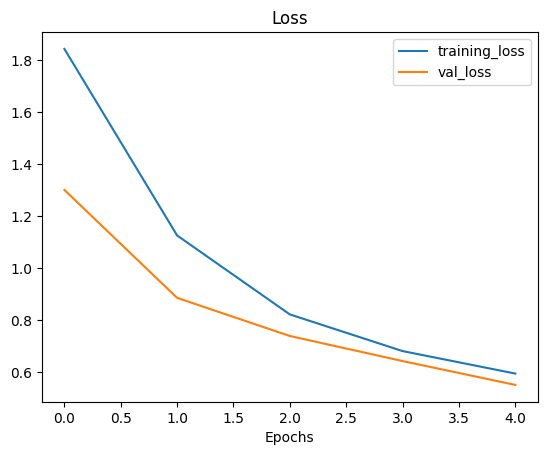

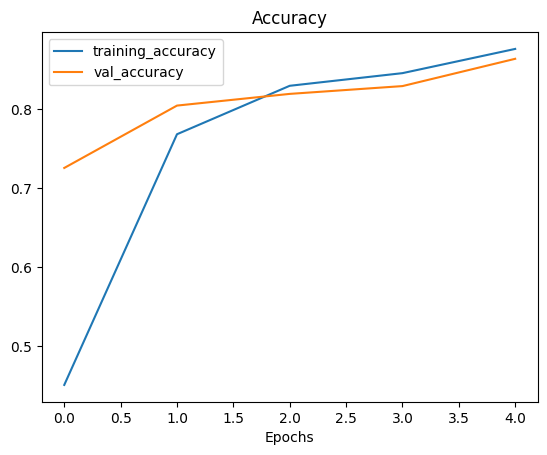

In [ ]:
# Plot loss curves
plot_loss_curves(history_0_10)

### What is a Feature Vector

* Is a learned representation of the input data (a compressed form of the input data)
* the average of the most important pattern of our data, just the patterns (weight and bias)


### Model 1: Use feature extraction transfer learning with 1% of data

In [5]:
#Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_1_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-02-15 18:25:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  31.2MB/s    in 4.9s    

2024-02-15 18:25:14 (26.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [6]:
# How many images are we working on
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [7]:
# Setup data
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

#Import data from directories and turn it into batches
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent, batch_size = 32, image_size= (224,224), label_mode= 'categorical') #Target size, redimension the image to fit in 224 pixels x 224 pixels
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir, batch_size = 32, image_size= (224,224), label_mode= 'categorical') #Turn the data into batches <BatchDataset>


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
 # Create data aumentation stage with horizontal flipping, rotations, zoom, etc.
 data_augmentation = tf.keras.Sequential([preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2)],
                                      name = 'data_augmentation')


In [9]:
 # Set up input shape
 input_shape = (224, 224, 3)
 base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
 base_model.trainable = False

 # Create the input layer
 inputs = layers.Input(shape = input_shape, name= 'input_layer')

 # Add data augmentation as a models layers
 x = data_augmentation(inputs)

 # Give base_model the inputs after augmentation
 x = base_model(x, training = False)

 # Pool output
 x = layers.GlobalAveragePooling2D()(x)

 # Put a dense layer on as the output
 outputs = layers.Dense(10, activation = "softmax", name = 'output_layer')(x)

 # Model 1
 model_1 = keras.Model(inputs, outputs)

 model_1.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics = ['accuracy'])



#### Model Checkpoint

In [20]:
# Create a checkpoint callback, save the model or only weights during training
checkpoint_path = 'transfer_learning/checkpoints/checkpoint.cktp'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                         save_weight_only = True,
                                                         save_best_only = True,
                                                         verbose = 1
                                                         )



In [13]:
 history_1 = model_1.fit(train_data_1_percent,
            epochs = 10,
            steps_per_epoch = len(train_data_1_percent),
            validation_data = test_data,
            validation_steps=int(0.10 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name = 'transfer_learning',
                                                  experiment_name = "1_percent_feature_extration"),
                       checkpoint_callback]
)


Saving TensorBoard log files to: transfer_learning/1_percent_feature_extration/20240215-183100
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.8286
Epoch 1: val_loss improved from inf to 1.45100, saving model to transfer_learning/checkpoints/checkpoint.cktp
3/3 [==============================] - 62s 30s/step - loss: 1.1154 - accuracy: 0.8286 - val_loss: 1.4510 - val_accuracy: 0.5759
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.8857
Epoch 2: val_loss improved from 1.45100 to 1.36277, saving model to transfer_learning/checkpoints/checkpoint.cktp
3/3 [==============================] - 54s 26s/step - loss: 1.0046 - accuracy: 0.8857 - val_loss: 1.3628 - val_accuracy: 0.6027
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.9429
Epoch 3: val_loss improved from 1.36277 to 1.33946, saving model to transfer_learning/checkpoints/checkpoint.cktp
3/3 [==============================

In [ ]:
model_1.evaluate(test_data)

In [24]:
# How to use the checkpoint
model_1.load_weights(checkpoint_path)

# Use evaluate to use
model_1.evaluate(test_data)

 2/79 [..............................] - ETA: 3:29 - loss: 1.1928 - accuracy: 0.6250

KeyboardInterrupt: 

### Model 2: Real Fine-Tuning Model

* Unfroozen some layers of the pretrained model
* So you can fine-tune those layers


In [25]:
# Check the layers of model 1
model_1.layers

In [26]:
# Are these layers trainable?
for layer in model_1.layers:
  print(layer, layer.trainable)


<keras.src.engine.input_layer.InputLayer object at 0x7a096c1e2e90> True
<keras.src.engine.sequential.Sequential object at 0x7a096c1e2800> True
<keras.src.engine.functional.Functional object at 0x7a095ed8ecb0> True
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a096c1e0820> True
<keras.src.layers.core.dense.Dense object at 0x7a095ed680a0> True


In [27]:
# Fine Tuning
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]: # This [:-10] is for all the layers except the last 10, not only the last 10
  layer.trainable = False

# Compile the model 2
model_1.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(0.0001), #In fine tuning typically you want to lower the learning rate 10x
                 metrics = ['accuracy'])



In [29]:
#Check the number of unfroozen layers
print(len(model_1.trainable_variables))

12


In [31]:
# Fine tune for another 5 epochs
fine_tune_epoch = 15 # 5 + 5 epochs

# Refit the model (same as model_1 except with more trainable layers)
history_2 = model_1.fit(train_data_1_percent,
            epochs = fine_tune_epoch,
            steps_per_epoch = len(train_data_1_percent),
            validation_data = test_data,
            validation_steps=int(0.10 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name = 'transfer_learning',
                                                  experiment_name = "1_percent_feature_extration")],
            initial_epoch = history_1.epoch[-1]) #Start training from the last epoch


Saving TensorBoard log files to: transfer_learning/1_percent_feature_extration/20240215-223132
Epoch 10/15
3/3 [==============================] - 26s 11s/step - loss: 0.5346 - accuracy: 0.9857 - val_loss: 1.0617 - val_accuracy: 0.6562
Epoch 11/15
3/3 [==============================] - 27s 12s/step - loss: 0.5418 - accuracy: 0.9714 - val_loss: 1.0655 - val_accuracy: 0.6384
Epoch 12/15
3/3 [==============================] - 21s 9s/step - loss: 0.4636 - accuracy: 0.9429 - val_loss: 0.9613 - val_accuracy: 0.6964
Epoch 13/15
3/3 [==============================] - 25s 11s/step - loss: 0.3954 - accuracy: 0.9857 - val_loss: 0.9899 - val_accuracy: 0.6562
Epoch 14/15
3/3 [==============================] - 17s 7s/step - loss: 0.4187 - accuracy: 0.9571 - val_loss: 1.0049 - val_accuracy: 0.6205
Epoch 15/15
3/3 [==============================] - 26s 12s/step - loss: 0.3363 - accuracy: 0.9857 - val_loss: 0.9235 - val_accuracy: 0.6562


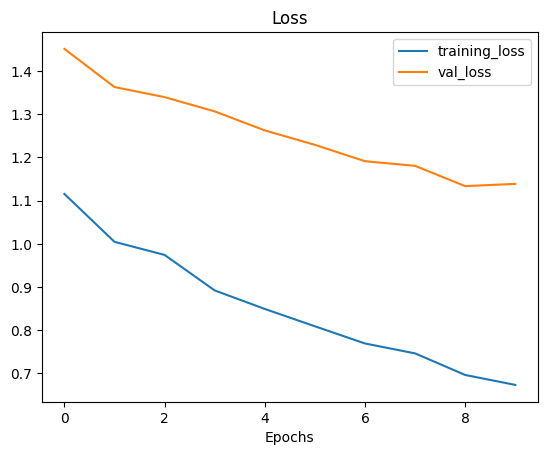

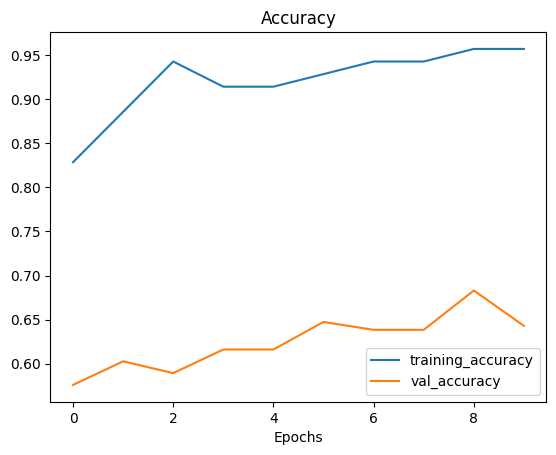

In [33]:
# Plot the loss curves
plot_loss_curves(history_1)

## Conclusions

* More data equals to less val_loss and more val_accuracy
* Fine-tuning and Checkpoints helps to get to higer accuracy with out overfitting
* Data augmentation also helps to get more accuracy
